<a href="https://colab.research.google.com/github/darrenpierre90/Image-recognition/blob/master/COMP4900A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code Setup
* importing required libaries needed for the project
* loading and transforming our datasets

In [0]:
from google.colab import drive
drive.mount('/content/gdrive' )
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import torch
import pandas as pd
from google.colab import files


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
ROOT_DIR="./gdrive/My Drive/Colab Notebooks/COMP4900A3/Data/"
TRAIN_P=ROOT_DIR+"Train.pkl"
TRAIN_L=ROOT_DIR+"TrainLabels.csv"
TEST_P=ROOT_DIR+"Test.pkl"
Kaggle=ROOT_DIR + "kaggleSubmission.csv"
# Read a pickle file and disply its samples
# Note that image data are stored as unit8 so each element is an integer value between 0 and 255
data = pickle.load( open( TRAIN_P, 'rb' ), encoding='bytes')
targets = np.genfromtxt(TRAIN_L, delimiter=',')


In [0]:
# Transforms are common image transformations. They can be chained together using Compose.
# Here we normalize images img=(img-0.5)/0.5
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [0]:
# img_file: the pickle file containing the images
# label_file: the .csv file containing the labels
# transform: We use it for normalizing images (see above)
# idx: This is a binary vector that is useful for creating training and validation set.
# It return only samples where idx is True
class MyDataset(Dataset):
    def __init__(self, img_file, label_file, transform=None, idx = None):
        self.data = pickle.load( open( img_file, 'rb' ), encoding='bytes')
        self.targets = np.genfromtxt(label_file, delimiter=',')
        if idx is not None:
          self.targets = self.targets[idx]
          self.data = self.data[idx]
        self.transform = transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])
        img = Image.fromarray(img.astype('uint8'), mode='L')

        if self.transform is not None:
           img = self.transform(img)

        return img, target

# Data set used for kaggle submission
class kaggleDS(Dataset):
    def __init__(self, img_file, transform=None,):
        self.data = pickle.load( open( img_file, 'rb' ), encoding='bytes')
        self.transform=transform
      

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index]
        img = Image.fromarray(img.astype('uint8'), mode='L')

        if self.transform is not None:
           img = self.transform(img)

        return img

dataset = MyDataset(TRAIN_P, TRAIN_L,transform=img_transform, idx=None)
batch_size = 256
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)



# Project Activities
* creating classes for models
* model training
* model testing
* model evaluation
*  accuracy and valdation accuracy to check for overfiitng

## Questions to explore 
* Epochs impact on performance
* impact on a CNN as we add more convulution layers
*  Using Max pooling vs Average poooling 
* use of Batch Normalization 
* Batch size has effect on NN


# Creating functions to train and test our models


In [0]:

def train(model,epoch,optimizer,use_gpu=False):
  train_losses = []
  train_counter = []
  if use_gpu:
    model.cuda() # put our model on the gpu
  model.train()
  
  loss_f = torch.nn.CrossEntropyLoss() # Loss function  
  for epoch in range(1,epoch+1):
    for batch_idx,(data) in enumerate(dataloader):
      [data,label]=data
      if use_gpu:
            data, label = data.cuda(), label.cuda()
      model.zero_grad()  # sets gradients to 0 before loss calc. 
      output = model(data) # model makes predictions
      loss = loss_f(output, label)  # calc and grab the loss value
      
      loss.backward()  # apply this loss backwards thru the network's parameters
      optimizer.step()  # attempt to optimize weights to account for loss/gradients
    
      if batch_idx % 20 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(dataloader.dataset),
          100. * batch_idx / len(dataloader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append(
          (batch_idx*64) + ((epoch-1)*len(dataloader.dataset)))
        
        
  fig = plt.figure()
  plt.plot(train_counter, train_losses, color='blue')
  plt.legend(['Train Loss'], loc='upper right')
  plt.xlabel('number of training examples seen')
  plt.ylabel('negative log likelihood loss')
  fig.show()

In [0]:

def test(model,use_gpu=False):
  correct = 0
  total = 0
  output=[]
  model.eval()
  if use_gpu:
    mode.cuda()
  with torch.no_grad():
      for data in dataloader:
          [data,label]=data
          data=data.cuda()
          label=label.cuda()
          output = model(data)
        
          for idx, i in enumerate(output):
              
              if torch.argmax(i) == label[idx]:
                  correct += 1
              total += 1
  accuracy=round(correct/total, 3)
  print("Accuracy: ",accuracy)
  return accuracy


In [0]:


# function to test for submission 
def testKaggle(model):
  fileName="kaggle submission.csv"
  submissionPD=pd.read_csv(Kaggle,header=0)
  output=[]
  kaggle_ds= kaggleDS(TEST_P,img_transform)
  kaggleDSLoader=DataLoader(kaggle_ds,10)
  for data in kaggleDSLoader:
    data=data.cuda()
    p_labels=model(data)
    output.append([torch.argmax(x) for x in p_labels])
  output=torch.flatten(torch.IntTensor(output),end_dim=1)
  output=torch.reshape(output,(1,10000))

  answer=list()

  for x in range(len(output[0])):
    answer.append(output[0][x].item())
  submissionPD.output=answer
  submissionPD.to_csv(fileName,index=False)
  files.download(fileName)




In [0]:

# Checking GPU availability
use_gpu = torch.cuda.is_available()

# First NN Model 
* I will be creating a Multi Layer Perceptron NN 
* This will serve as a baseline model for us as CNN are better than MLP NN
* [Pytorch basics](https://www.analyticsvidhya.com/blog/2019/09/introduction-to-pytorch-from-scratch/?utm_source=blog&utm_medium=how-to-master-transfer-learning-using-pytorch)

In [0]:
import torch.nn as nn
import torch.nn.functional as F
# loss functions check out this link to learn more :https://medium.com/udacity-pytorch-challengers/a-brief-overview-of-loss-functions-in-pytorch-c0ddb78068f7
# based on this tutorial : https://www.youtube.com/watch?v=BzcBsTou0C0&list=PLQVvvaa0QuDdeMyHEYc0gxFpYwHY2Qfdh
class Net(nn.Module):
    def __init__(self, hidden_size):
        INPUT_SIZE=64*128
        OUTPUTSIZE=10
        super(Net, self).__init__()                    # Inherited from the parent class nn.Module
        self.fc1 = nn.Linear(INPUT_SIZE, hidden_size)  # nn.Linear multiples input by weights and add a bias
        self.fc2 = nn.Linear(hidden_size, hidden_size) 
        self.fc3 = nn.Linear(hidden_size, OUTPUTSIZE)  
       
    def forward(self, x):  
        x=torch.flatten(x,start_dim=1)      #flatten our image to a vector                      # Forward pass: stacking each layer together
        out = F.relu(self.fc1(x))        #activation function uses relu
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        return out 

# Basic Convolutional NN
* Larger number of out channels , learn more features of the picture, matter of preference
* size of conv layer is affect by in_channel , out_channel and how many channels
* kernal_size = N square filter , can be given as a tuple. Common dimensions include 1×1, 3×3, 5×5, and 7×7 which can be passed as (1, 1), (3, 3), (5, 5), or (7, 7) tuples.
* Don't change stride or padding , unless have good reasons to do so

# Alex Net 
* The following model is based on the the following archtechture 
* Since we are not dealing with the same input dimentsions .
* The dimensions are not reflective of the original archtechture but the structure and propeties are inspried by this NN



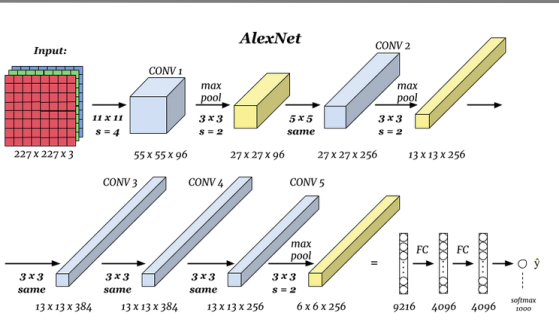


In [0]:
#Original 
class Alexnet_Original(nn.Module):
  def __init__(self):
    super(Alexnet_Original,self).__init__()
    self.conv1= nn.Conv2d(in_channels=1,out_channels=96,kernel_size=7,stride=1,padding=1)
    self.conv2= nn.Conv2d(96,256,5)
    self.conv3= nn.Conv2d(256,384,3)
    self.conv4= nn.Conv2d(384,384,3)
    self.conv5= nn.Conv2d(384,256,3)
    self.pool1=nn.MaxPool2d(2)
    self.batch1=nn.BatchNorm2d(96)
    self.batch2=nn.BatchNorm2d(256)
    
    self.drop1=nn.Dropout(0.25)
    self.drop2=nn.Dropout(0.20)
    self.fc1 = nn.Linear(8448, 800)
    self.fc2 = nn.Linear(800, 200)
    self.fc3 = nn.Linear(200, 10)
    

  def forward(self, X):
    X = F.relu(self.pool1(self.batch1(self.conv1(X))))
    X = F.relu(self.pool1(self.batch2((self.conv2(X)))))
    X = F.relu((self.conv3(X))) 
    X = F.relu((self.conv4(X))) 
    X = F.relu(self.pool1(self.conv5(X))) 
    X = X.flatten(1)
    X = F.relu((self.fc1(X)))
    X = F.relu((self.fc2(X)))
    X = self.drop2(self.fc3(X))
    return F.softmax(X)   

In [0]:
# Modified Alexnet
class Alexnet_M(nn.Module):
  def __init__(self):
    super(Alexnet_M,self).__init__()
    self.conv1= nn.Conv2d(in_channels=1,out_channels=40,kernel_size=7,stride=1,padding=1)
    self.conv2= nn.Conv2d(40,80,5)
    self.conv3= nn.Conv2d(80,160,3)
    self.conv4= nn.Conv2d(160,320,3)
    self.conv5= nn.Conv2d(320,400,3)
    self.pool1=nn.MaxPool2d(2)
    self.drop1=nn.Dropout(0.25)
    self.drop2=nn.Dropout(0.20)
    self.fc1 = nn.Linear(13200, 800)
    self.fc2 = nn.Linear(800, 200)
    self.fc3 = nn.Linear(200, 10)

  def forward(self, X):
    X = F.relu(self.pool1(self.conv1(X)))
    X = F.relu(self.pool1(self.conv2(X))) 
    X = F.relu((self.conv3(X))) 
    X = F.relu((self.conv4(X))) 
    X = F.relu(self.pool1(self.conv5(X))) 
    X = X.flatten(1)
    X = F.relu(self.drop1(self.fc1(X)))
    X = F.relu(self.drop2(self.fc2(X)))
    X = self.drop2(self.fc3(X))
    return F.softmax(X)  

In [0]:
# Neural net for experimenting with layers and hyperparameters
class Temp(nn.Module):
  def __init__(self):
    super(Temp,self).__init__()
    self.conv1= nn.Conv2d(in_channels=1,out_channels=96,kernel_size=7,stride=1,padding=1)
    self.conv2= nn.Conv2d(96,256,5)
    self.conv3= nn.Conv2d(256,384,3)
    self.conv4= nn.Conv2d(384,384,3)
    self.conv5= nn.Conv2d(384,256,3)
    self.pool1=nn.MaxPool2d(2)
    self.batch1=nn.BatchNorm2d(96)
    self.batch2=nn.BatchNorm2d(256)
    
    self.drop1=nn.Dropout(0.25)
    self.drop2=nn.Dropout(0.20)
    self.fc1 = nn.Linear(8448, 800)
    self.fc2 = nn.Linear(800, 200)
    self.fc3 = nn.Linear(200, 10)
    

  def forward(self, X):
    X = F.relu(self.pool1(self.batch1(self.conv1(X))))
    X = F.relu(self.pool1(self.batch2((self.conv2(X)))))
    X = F.relu((self.conv3(X))) 
    X = F.relu((self.conv4(X))) 
    X = F.relu(self.pool1(self.conv5(X))) 
    X = X.flatten(1)
    X = F.relu((self.fc1(X)))
    X = F.relu((self.fc2(X)))
    X = self.drop2(self.fc3(X))
    return F.softmax(X)   

In [0]:
def trainModel():
  model=Temp()
  optimizer=torch.optim.Adam(model.parameters(),lr=5e-5) #5e-4
  train(model,20,optimizer,use_gpu)
  test(model)


In [0]:
def saveModel(model,name="bestModel.dict"):
  PATH= ROOT_DIR+name
  torch.save(model.state_dict(), PATH)
  print(f"your model has been saved to {PATH}")


def loadModel(ModelClass,name):
  PATH=ROOT_DIR + name
  model = ModelClass()
  model.load_state_dict(torch.load(PATH))
  return model


# Transfer Learning with Pytorch
* using a pre-train model as a starting point 
* Transfer learning only works in deep learning if the model features learned from the first task are general.
*  all models are trained using the Imagenet dataset

## Transfer Learning scenarios

1. Convet as fixed feature extractor:Take a pretrained CNN and remove the last layer and treat the rest of the network as a feature extractor.Then train a linear classifier for the new dataset.

2. Fine-tuning the ConvNet:Retrain the whole network and replace the last layer.


## Resources
* [Models to choose from ](https://pytorch.org/docs/stable/torchvision/models.html#classification)
* [Transfer Learning scenarios](http://cs231n.github.io/transfer-learning/)
* [Detailed explanation to Transfer Learning](https://medium.com/georgian-impact-blog/transfer-learning-part-1-ed0c174ad6e7)
* [A Comprehensive Hands-on Guide to Transfer Learning with Real-World Applications in Deep Learning](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a)
*[Transfer Learning with pytorch](https://www.analyticsvidhya.com/blog/2019/10/how-to-master-transfer-learning-using-pytorch/)



In [0]:
from PIL import Image
"""
This functions is used to transform a PIL image into a rgb image
We created this function because we need to format our images into something 
"""
def rgb(pil):
  copy=np.zeros((64,128,3))
  a = np.asarray(pil)

  for x in range(64):
    for y in range(128):
      value=a[x][y]
      copy[x][y]=[value,value,value]

  return  Image.fromarray(copy.astype('uint8'), 'RGB')



In [0]:
transform_learning_transform=transforms.Compose([
                                                 transforms.Lambda(rgb),
                                                 transforms.Resize(224),
                                                 transforms.ToTensor(),                              
                                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
                                          ])


In [0]:
import torchvision.models as models
alexnet = models.alexnet(True)
dataset = MyDataset(TRAIN_P, TRAIN_L,transform=transform_learning_transform, idx=None)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [0]:
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(9216, 4096)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(4096, 10)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

In [0]:
alexnet.classifier=classifier
optimizer=torch.optim.Adam(alexnet.parameters(),lr=5e-5) #5e-4

train(alexnet,1,optimizer,use_gpu)

In [0]:
test(alexnet)

# Snapshot Ensembles

* Collect multiple models from a single training run.
*A limitation of collecting multiple models during a single training run is that the models may be good, but too similar.
* This can be addressed by changing the learning algorithm for the deep neural network to force the exploration of different network weights during a single training run that will result, in turn, with models that have differing performance. One way that this can be achieved is by aggressively changing the learning rate used during training.

* To avoid this issue , you can change the learning algorithm for your NN to force different parameters duiring a single traiing run . As of result the models will have differing performance . One method of doing this is aggressively changing the learnin rate used during training.

* There's multiple ways to aggressively change the learning rate . Among the 2 sources , they used **cosine annealing** .But there's other methods .


## References 
[SNAPSHOT ENSEMBLES: TRAIN 1, GET M FOR FREE](https://arxiv.org/abs/1704.00109)

[Snapshot Ensemble Deep Learning Neural Network With Keras](https://machinelearningmastery.com/snapshot-ensemble-deep-learning-neural-network/)